## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
#Read data 
df = pd.read_csv('ab_data.csv') 

#First few rows of the data 
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
a = df.query('landing_page == "new_page" and group != "treatment"')
b = df.query('landing_page == "old_page" and group != "control"')
a.count() + b.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
#Dropping the rows that are inconsistent
df2 = df.drop(a.index, axis=0)
df2 = df2.drop(b.index, axis=0)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

**user_id** repeated in **df2**

In [11]:
mask = df2.user_id.duplicated()

print (df2[mask])


      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop_duplicates(inplace = True)

 What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2.converted.mean()

0.11959667567149027

Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
df2.query('group == "control" and converted == 1')['user_id'].count() / df2.query('group == "control"')['user_id'].count()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
df2.query('group == "treatment" and converted == 1')['user_id'].count() / df2.query('group == "treatment"')['user_id'].count()

0.11880724790277405

What is the probability that an individual received the new page?

In [16]:
df2.query('landing_page == "new_page"')['user_id'].count() / df2.user_id.count()

0.5000636646764286

**Observations** 

-  The control group has a higher conversion, although not significantly higher than the treatment group (Control:0.12 , Treatment:0.118)
- In other words, the old_page has slightly higher conversion 
- Probability that an individual received a page if 0.5 
- These results do not provide sufficient evidence to prove if the new treatment page leads to more conversions 


<a id='ab_test'></a>
### Part II - A/B Test

Conssidering you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- Null hypothesis: **$p_{new}$** <= **$p_{old}$**
- Alternate Hypothesis:  **$p_{new}$** > **$p_{old}$**

What is the **conversion rate** for $p_{new}$ under the null? 

In [17]:
#Assuming that $p_{new}$ = $p_{old}$ = converted rate 

p_new = df2.query('converted == 1')['user_id'].count() / df2['user_id'].count()
p_new

0.11959667567149027

What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [18]:
p_old = df2.query('converted == 1')['user_id'].count() / df2['user_id'].count()
p_old

0.11959667567149027

What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
n_new = df2.query('group == "treatment"')['user_id'].nunique()
n_new

145310

What is $n_{old}$, the number of individuals in the control group?

In [20]:
n_old = df2.query('group == "control"')['user_id'].nunique()
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = np.random.binomial(n_new, p_new)

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = np.random.binomial(n_old, p_old)

Find $p_{new}$ - $p_{old}$ for your simulated values 

In [23]:
new_page_converted/n_new - old_page_converted/n_old

-0.0025143685943856964

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
p_diffs = [] 
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append(new_page_converted/n_new - old_page_converted/n_old)
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

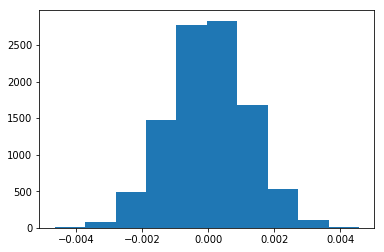

In [25]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [26]:
p_obs_new = df2.query('group == "treatment"')['converted'].mean() 
p_obs_old = df2.query('group == "control"')['converted'].mean()
p_diffs = np.array(p_diffs)
obs_diff = p_obs_new - p_obs_old
(p_diffs > obs_diff).mean()

0.9087

**Observation**
- This value is the p-value 
- Here, p value is very high. This means that we fail to reject our null hypothesis 
- Here, we find that there is no added advantage of new_page when it comes to conversion. The numbers above show that old_page performed slightly better 

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [27]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1')['user_id'].count()
convert_new = df2.query('group == "treatment" and converted == 1')['user_id'].count()
n_old = df2.query('group == "control"')['user_id'].count()
n_new = df2.query('group == "treatment"')['user_id'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [28]:
convert_old

17489

Use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print("z_score:",z_score)
print("p_value: ",p_value)

z_score: 1.3116075339133115
p_value:  0.905173705140591


In [30]:
from scipy.stats import norm

#Significance of z_score
print(norm.cdf(z_score))

print(norm.ppf(1-(0.05)))


0.905173705140591
1.6448536269514722


**Observation** 

- We find that the z-score(1.310) is less than the critical value(1.644). This is in favor of null hypothesis.
- Based on conversion rates of the old and new pages, we find that old pages are only minutely better than new pages.
- These values agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach


Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
page_received = pd.get_dummies(df.landing_page)
df2 = df2.join(page_received)

In [32]:
df2[['control','ab_page']] = pd.get_dummies(df.group)

In [33]:
df2.drop('control',axis = 1, inplace=True)

In [34]:
df2.columns
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Apr 2019   Pseudo R-squ.:               8.085e-06
Time:                        16:33:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Observation**

The hypothesis for this case is as below:
1. H0: p_old = p_new 
2. H1:p_old != p_new

**How do they compare to the null and alternative hypotheses in Part II?**
- Directional component is different in hypotheses here and that of Part II 


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

In [37]:
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

**Observation**

1. Timesatamp can be used to see if there are hours in a day with higher conversion rate 
2. Factors like change aversion can provide better insight 
3. Factors like gende and educational background can also help us with better analysis 

**Disadvantage of considering multiple factors** 
1. Including more number of factors can make it difficult to understand the significance of features individually 
2. There might be relationship between individual features itself that might not be accounted for 
3. Adding more features also increases the run time for the model to fit 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [39]:
pd.get_dummies(df_new.country).head()

#We can have just two dummy variables 

,CA,UK,US
user_id,,,
630000,0,0,1
630001,0,0,1
630002,0,0,1
630003,0,0,1
630004,0,0,1


In [40]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new.country)

In [41]:
df_new.drop('CA',axis = 1, inplace = True)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
df_new['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','US','UK','ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Thu, 25 Apr 2019   Pseudo R-squ.:               2.324e-05
Time:                        16:33:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
==============================================================================
"""

In [43]:
np.exp(0.0408), np.exp(0.0506),np.exp(-.0150)

(1.0416437559600236, 1.0519020483004984, 0.9851119396030626)

In [44]:
df.groupby('group').mean()['converted']


group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

**Observation** 

- p-values for US, UK and ab_page are low in value(statistically significant) 
- Because of low p-value in this case, we reject our null hypothesis(p_new = p_old). Based on this we can say that new_page conversion is not equal to that of old_page 
- Conversion in US is 1.04 times as that of Canada 
- Conversion in UK is 1.051 times as that of Canada 
- old_page still seems to do slightly better in terms of conversion 

**Conclusion**

1. Evidence for null hypothesis is stronger than for alternate hypothesis. Hence we accept null hypothesis and reject alternate hypothesis 
2. Conversion for old_page is slightly higher than new_page based on above data 
3. These results are solely based on the data provided 
4. Whether or not other factors can provide us with better insight has not been explored in depth 

<a id='conclusions'></a>
## Finishing Up


In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0